# Sentiment Analysis Pipeline

Script for NLP project.

## Config

In [53]:
data_path = "train.csv"

## Imports

In [54]:
!pip install transformers==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
  Using cached sentencepiece-0.1.97-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached tokenizers-0.8.1rc1.tar.gz (97 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sacremoses-0.0.53-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [55]:
# !pip install torch==1.10

In [56]:
import gc
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from torch import cuda
from tqdm import tqdm
from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

## Read Data

In [57]:
data = pd.read_csv(data_path)
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


## Describe Data

In [58]:
data.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
116280,6da531660dab3ccf,Carry out discussion on relevant pages,0,0,0,0,0,0
98473,0ebeac0c372d8588,circulus in demonstrando\nVGChartz is credible...,0,0,0,0,0,0
149010,558cd880f4d61180,. Albert was also active with the National Arb...,0,0,0,0,0,0
82448,dc99fb85ecd6fee7,"""\n\n Blah Blah Blah \n\nEvery edit you ever m...",0,0,0,0,0,0
68151,b65227096e67d6f3,"""comic sans ms; font-variant: small-caps"""">Ner...",0,0,0,0,0,0
107949,4105ca8feb435f11,"""\nOoops! I was tagging all the Iron Maiden to...",0,0,0,0,0,0
27568,48f83052d0b8d17a,Is it true? Can you support your assertion wit...,0,0,0,0,0,0
104805,30b9256c5e0e7fad,"""\n\nThanks for you Barnstar award\n\nI notice...",0,0,0,0,0,0
31071,528ae515d2d8fb55,"""{| style=""""background-color:#F5FFFA; padding:...",0,0,0,0,0,0
119246,7d789a0f5e4bf8f1,"Bug report from Uncyclopedia\nHya, since the l...",0,0,0,0,0,0


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## Explore Data

In [60]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


0    144277
1     15294
Name: toxic, dtype: int64

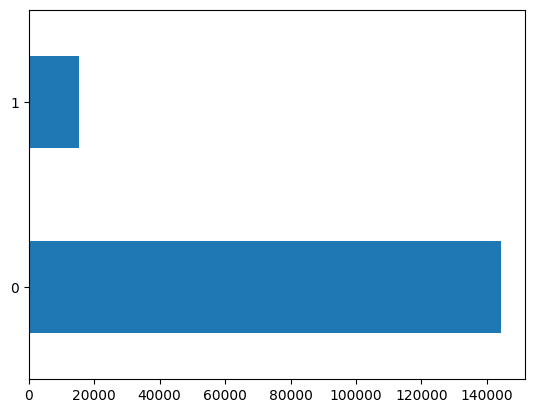

In [61]:
data["toxic"].value_counts().plot(kind="barh")
data["toxic"].value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

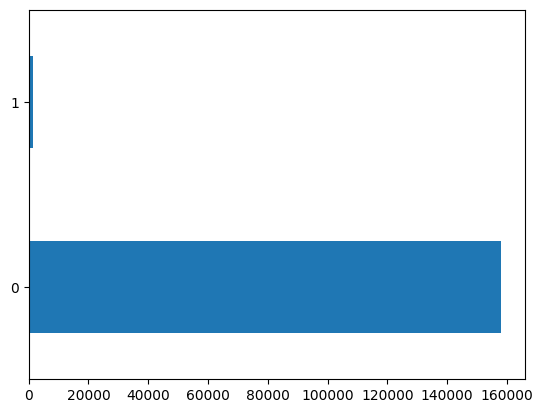

In [62]:
data["severe_toxic"].value_counts().plot(kind="barh")
data["severe_toxic"].value_counts()

0    151122
1      8449
Name: obscene, dtype: int64

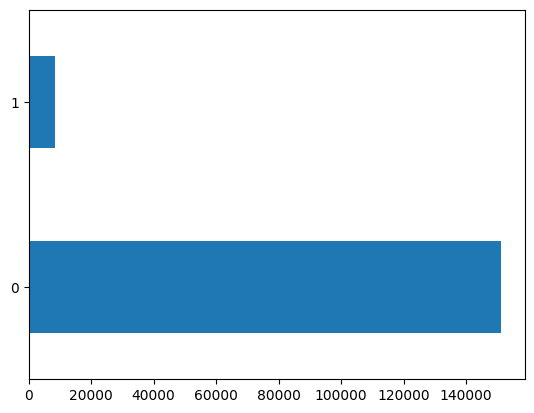

In [63]:
data["obscene"].value_counts().plot(kind="barh")
data["obscene"].value_counts()

0    159093
1       478
Name: threat, dtype: int64

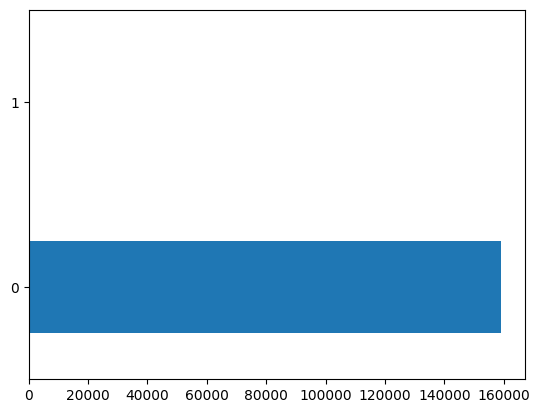

In [64]:
data["threat"].value_counts().plot(kind="barh")
data["threat"].value_counts()

0    159093
1       478
Name: threat, dtype: int64

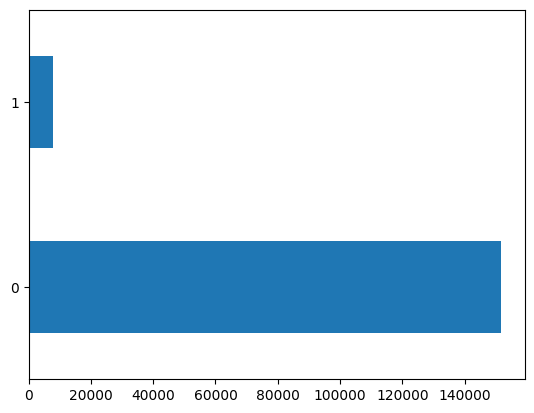

In [65]:
data["insult"].value_counts().plot(kind="barh")
data["threat"].value_counts()

0    158166
1      1405
Name: identity_hate, dtype: int64

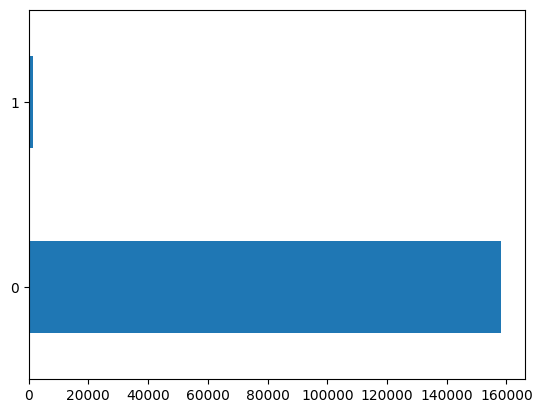

In [66]:
data["identity_hate"].value_counts().plot(kind="barh")
data["identity_hate"].value_counts()

<ipython-input-67-7e6ce141f653>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='flare')


<Axes: >

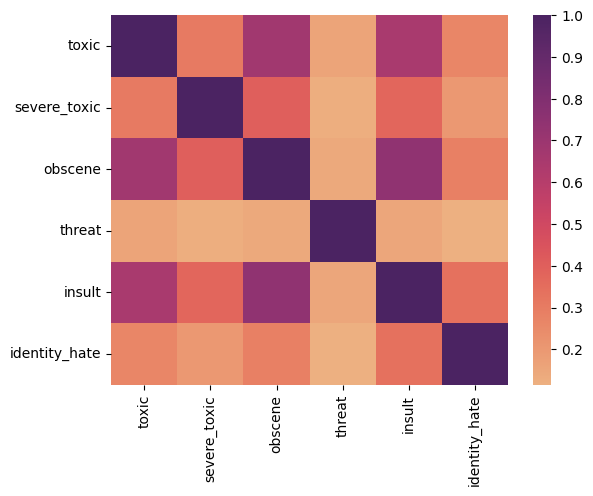

In [67]:
sns.heatmap(data.corr(), cmap='flare')

## Verify Data Quality

In [68]:
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

No null values - good.

## Preprocessing

### Merge Toxic Columns to Single One

In [69]:
data = pd.concat([data["comment_text"], 
                  data.drop(
                      ["id", "comment_text"], axis=1
                  ).apply(lambda row: any(row), axis=1)], 
                 axis=1)
data

,comment_text,0
0,Explanation\nWhy the edits made under my usern...,False
1,D'aww! He matches this background colour I'm s...,False
2,"Hey man, I'm really not trying to edit war. It...",False
3,"""\nMore\nI can't make any real suggestions on ...",False
4,"You, sir, are my hero. Any chance you remember...",False
...,...,...
159566,""":::::And for the second time of asking, when ...",False
159567,You should be ashamed of yourself \n\nThat is ...,False
159568,"Spitzer \n\nUmm, theres no actual article for ...",False
159569,And it looks like it was actually you who put ...,False


### Balance Classes

In [70]:
df_majority = data[data[0]==False]
df_minority = data[data[0]==True]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled[0].value_counts()

False    16225
True     16225
Name: 0, dtype: int64

In [71]:
df_downsampled = df_downsampled.sample(frac=1)
df_downsampled

,comment_text,0
34105,""":I've removed the article issues template whi...",False
64462,"Did, WHAT DID I JUST SAY!? Sourcing VA's is u...",True
68371,"""\n\nIndeed. I seem to recall a convo several ...",False
111369,Mom of Ivy Blue Carter,False
39261,File:Yabazu logo blk.jpg listed for deletion \...,False
...,...,...
123388,"! YOU'RE AN IGNORANT PHALLUS-SUCKER, NO MATTER...",True
157936,FUCK OFF YOU CRYBABY SHIT OF A MAN,True
97200,If you're not an old lefty then you don't even...,True
140387,"Oh, did little mrs. pussy get his feelings hur...",True


(0.0, 1000.0)

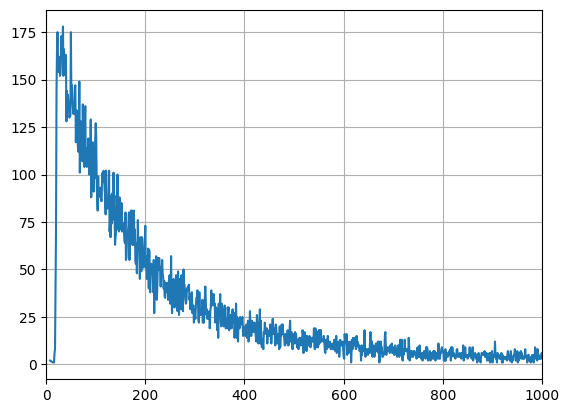

In [72]:
# let us see distribution of length to define a value of SEQ_LEN
from collections import Counter
from matplotlib import pyplot as plt

cnt = Counter((len(seq) for seq in df_downsampled["comment_text"]))
cnt = sorted(dict(cnt).items())
plt.plot([key for key, val in cnt], [val for key, val in cnt])
plt.grid()
plt.xlim(0, 1000)

In [73]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

In [74]:
# tokenized_train = tokenizer(df_downsampled["comment_text"].values.tolist(), padding=True, truncation=True, return_tensors="pt")
# tokenized_val = tokenizer(df_downsampled["comment_text"].values.tolist(), padding=True, truncation=True,  return_tensors="pt")

# print(tokenized_train.keys())

# #move on device (GPU)
# tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
# tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

In [75]:
# with torch.no_grad():
#   hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
#   hidden_val = model(**tokenized_val)

# #get only the [CLS] hidden states
# cls_train = hidden_train.last_hidden_state[:,0,:]
# cls_val = hidden_val.last_hidden_state[:,0,:]

In [76]:
# x_train = cls_train.to("cpu")
# y_train = df_downsampled[0]

# x_val = cls_val.to("cpu")
# y_val = df_downsampled[0]

# print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)


# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier()
# rf.fit(x_train,y_train)
# rf.score(x_val,y_val) 

In [77]:
# raise Exception()

In [78]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 128  # TODO try 400 and 200
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
device = "cuda" if cuda.is_available() else "cpu"

In [79]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.comment_text
        self.targets = self.data[0]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor([self.targets[index]], dtype=torch.float)
        }

In [80]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_data = df_downsampled.sample(frac=train_size,random_state=200)
test_data = df_downsampled.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(df_downsampled.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN)

FULL Dataset: (32450, 2)
TRAIN Dataset: (25960, 2)
TEST Dataset: (6490, 2)


In [81]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [94]:
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
model.to(device)

embeddings = []

with torch.no_grad():
    for _, data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        print(ids.shape)
        print(mask.shape)
        print(token_type_ids.shape)
        outputs = model(input_ids=ids, attention_mask=mask)
        hidden_state = outputs[0]
        pooler = hidden_state[:, 0]
        print(pooler)
        raise Exception()

#get only the [CLS] hidden states

cls_train

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([4, 128])
tensor([[-0.2317, -0.0528,  0.1080,  ..., -0.1515,  0.2261,  0.2573],
        [ 0.1768,  0.0965, -0.1401,  ..., -0.1045,  0.5364,  0.3127],
        [ 0.0876,  0.1589,  0.0148,  ..., -0.1027,  0.4730,  0.2323],
        [-0.2873, -0.1527, -0.0880,  ..., -0.1592,  0.2366,  0.6472]],
       device='cuda:0')


Exception: ignored

# EMBEDDING IS OBTAINED - NEED TO CLASSIFY

In [ ]:
raise Exception()

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return torch.sigmoid(output)

model = DistilBERTClass()
model.to(device)

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCELoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    model.train()
    for _, data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()

In [ ]:
# del model
# gc.collect()
torch.cuda.empty_cache()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation(testing_loader)

final_outputs = np.array(outputs) >=0.5

In [ ]:
metrics.accuracy_score(targets, final_outputs)

In [ ]:
targets[:10]

In [ ]:
all(final_outputs)

In [ ]:
raise Exception()

In [ ]:
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

In [ ]:
# Saving the files for inference

output_model_file = './models/pytorch_distilbert_news.bin'
output_vocab_file = './models/vocab_distilbert_news.bin'

torch.save(model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved')

### Divide by Input and Target

In [ ]:
X = df_downsampled["comment_text"]
y = df_downsampled[0]
X

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1)

## Constructing a Model

### Encoder

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = DistilBertModel.from_pretrained("distilbert-base-multilingual-cased")

device = "cuda:0" if cuda.is_available() else "cpu"
model = model.to(device)

Embed input sentences

In [ ]:
# tokenize
X_train = X_train.apply(lambda row: tokenizer(row, return_tensors='pt', max_length=512).to(device))

In [ ]:
cuda.empty_cache()

In [ ]:
# embed
batch_size = 1
temp = X_train[:batch_size].apply(lambda row: model(**row).last_hidden_state)
for i in range(batch_size, len(X_train), batch_size):  # 14 sec / 1000 samples | 86 sec / 10k samples
    temp = np.vstack([temp, X_train[i:i+batch_size].apply(lambda row: model(**row).last_hidden_state)])
X_train = temp

In [ ]:
# cuda.empty_cache()
# gc.collect()

batch_size = 100
temp = X[:batch_size].apply(lambda row: get_features(row))
for i in range(batch_size, len(X_train), batch_size):  # 14 sec / 1000 samples | 86 sec / 10k samples
    temp = np.vstack([temp, X[i:i+batch_size].apply(lambda row: get_features(row))])
    cuda.empty_cache()
X_train = temp

### Classifier

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC()

## Train

In [ ]:
clf.fit(X_train, y_train)

## Test

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))